<a href="https://colab.research.google.com/github/seeverblog/BCDU-Ne/blob/master/Merge_InceptionV3_Resnetinception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import glob
import numpy as np
import os
import shutil
np.random.seed(42)
from sklearn.preprocessing import LabelEncoder
import cv2
import tensorflow as tf
import shutil
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, cohen_kappa_score

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
os.chdir('/content/drive/My Drive/Colab Notebooks/DATA RD/')

In [0]:
path = glob.glob("/content/drive/My Drive/Colab Notebooks/DATA RD/DATA KAGGLE/DATA GLOB/*.jpeg")
cv_img = []
for img in path:
    img2= cv2.imread(img,-1)
    #print(img)
    #print(img2)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    b,g,r=cv2.split(img2)
    cl_b = clahe.apply(b)
    cl_g = clahe.apply(g)
    cl_r = clahe.apply(r)
    cl_rgb = cv2.merge([cl_b,cl_g,cl_r]);
    cv2.imwrite(img,cl_rgb)

In [0]:
files = glob.glob('/content/drive/My Drive/Colab Notebooks/DATA RD/DATA KAGGLE/DATA GLOB/*')
files2 = glob.glob('/content/drive/My Drive/Colab Notebooks/DATA RD/MESEIDOR/DATA GLOB/*')

In [5]:
len (files), len (files2)

(7723, 1200)

In [6]:
train_imgs = [fn for fn in files+files2]
len(train_imgs)

8923

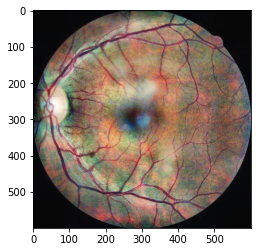

In [9]:
import matplotlib.image as mpimg
for ima in train_imgs[0:1]:
     img=mpimg.imread(ima)
     imgplot = plt.imshow(img)
     plt.show()

In [0]:
nrows = 299
ncolumns = 299
channels = 3  

def read_and_process_image(list_of_images):
    
    X = [] # images
    y = [] # labels
    
    for image in list_of_images:
        X.append(cv2.resize(cv2.imread(image, cv2.IMREAD_COLOR), (nrows,ncolumns), interpolation=cv2.INTER_CUBIC))  #Read the image
        #get the labels
        if 'Normal' in image:
            y.append(0)
        elif 'Mild' in image:
            y.append(1)
        elif 'Moderate' in image:
            y.append(2)
        elif 'Severe' in image:
            y.append(3)

    
    return X, y

In [0]:
X, y = read_and_process_image(train_imgs)

Text(0.5, 1.0, 'Total images of each class')

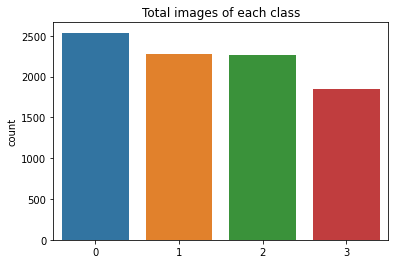

In [13]:
import seaborn as sns
import gc 
gc.collect()

#Convert list to numpy array
X = np.array(X)
y = np.array(y)

#Lets plot the label to be sure we just have two class
sns.countplot(y)
plt.title('Total images of each class')

In [14]:
print("Shape of train images is:", X.shape)
print("Shape of labels is:", y.shape)

Shape of train images is: (8923, 299, 299, 3)
Shape of labels is: (8923,)


In [0]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,stratify=np.array(y),random_state=2)


In [16]:
print("Shape of train images is:", X_train.shape)
print("Shape of validation images is:", X_val.shape)
print("Shape of labels is:", y_train.shape)
print("Shape of labels is:", y_val.shape)

Shape of train images is: (7138, 299, 299, 3)
Shape of validation images is: (1785, 299, 299, 3)
Shape of labels is: (7138,)
Shape of labels is: (1785,)


In [0]:
del X
del y
gc.collect()

#get the length of the train and validation data
ntrain = len(X_train)
nval = len(X_val)

#We will use a batch size of 32. Note: batch size should be a factor of 2.***4,8,16,32,64...***
batch_size = 32

In [18]:
y_train_ohe = pd.get_dummies(y_train)
y_val_ohe=pd.get_dummies(y_val)

y_train_ohe.shape,y_val_ohe.shape

((7138, 4), (1785, 4))

In [0]:
IMG_SHAPE = (192, 256, 3)
base_model = tf.keras.applications.densenet.DenseNet201(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
x = base_model.output
x =tf.keras.layers.GlobalMaxPooling2D()(x)
x =tf.keras.layers.Dense(512, activation='relu')(x)
x =tf.keras.layers.Dropout(0.5)(x)
x =tf.keras.layers.Dense(4, activation='softmax')(x)
model = tf.keras.models.Model(inputs=base_model.inputs, outputs=x)

In [0]:
for layer in base_model.layers:
    layer.trainable = False

In [0]:
optimizer =tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

In [0]:
train_datagen =tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,   
                                    rotation_range=60,
                                    width_shift_range=0.2, 
                                    height_shift_range=0.2,
                                    shear_range=0.2, zoom_range=0.2, 
                                    fill_mode='nearest',
                                    preprocessing_function=tf.keras.applications.resnet.preprocess_input)

In [0]:
train_generator = train_datagen.flow(X_train, y_train_ohe, batch_size=batch_size)
val_generator = train_datagen.flow(X_val, y_val_ohe, batch_size=batch_size)

In [0]:
train_generator = train_datagen.flow(X_train, y_train_ohe, batch_size=batch_size)
val_generator = train_datagen.flow(X_val, y_val_ohe, batch_size=batch_size)

In [0]:
learning_rate_reduction =tf.keras.callbacks.ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, 
                                            min_lr=0.000001, cooldown=2)

In [26]:
history1 = model.fit_generator(train_generator,
                              steps_per_epoch=ntrain // batch_size,
                              epochs=75,
                              validation_data=val_generator,
                              validation_steps=nval // batch_size,callbacks=[learning_rate_reduction])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/75
223/223 [==============================] - 152s 682ms/step - loss: 1.9671 - acc: 0.3575 - val_loss: 1.2077 - val_acc: 0.4574 - lr: 1.0000e-04
Epoch 2/75
223/223 [==============================] - 150s 675ms/step - loss: 1.2388 - acc: 0.4313 - val_loss: 1.1670 - val_acc: 0.4733 - lr: 1.0000e-04
Epoch 3/75
223/223 [==============================] - 150s 671ms/step - loss: 1.2090 - acc: 0.4467 - val_loss: 1.1434 - val_acc: 0.5000 - lr: 1.0000e-04
Epoch 4/75
223/223 [==============================] - 149s 670ms/step - loss: 1.1826 - acc: 0.4579 - val_loss: 1.1322 - val_acc: 0.5045 - lr: 1.0000e-04
Epoch 5/75
223/223 [==============================] - 149s 670ms/step - loss: 1.1669 - acc: 0.4678 - val_loss: 1.1177 - val_acc: 0.5097 - lr: 1.0000e-04
Epoch 6/75
223/223 [==============================] - 150s 673ms/step - loss: 1.1401 - acc: 0.4876 - val_loss: 1.1074 - val_acc: 0.5125 - lr: 1.0000e-04
Epoch 

In [30]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=ntrain // batch_size,
                              epochs=25,
                              validation_data=val_generator,
                              validation_steps=nval // batch_size,callbacks=[learning_rate_reduction])

Epoch 1/25
223/223 [==============================] - 164s 735ms/step - loss: 1.8261 - acc: 0.4396 - val_loss: 1.1253 - val_acc: 0.5131 - lr: 1.0000e-04
Epoch 2/25
223/223 [==============================] - 160s 719ms/step - loss: 1.0498 - acc: 0.5356 - val_loss: 0.9600 - val_acc: 0.5903 - lr: 1.0000e-04
Epoch 3/25
223/223 [==============================] - 158s 707ms/step - loss: 0.9791 - acc: 0.5732 - val_loss: 0.8809 - val_acc: 0.6301 - lr: 1.0000e-04
Epoch 4/25
223/223 [==============================] - 157s 705ms/step - loss: 0.9269 - acc: 0.6003 - val_loss: 0.8856 - val_acc: 0.6267 - lr: 1.0000e-04
Epoch 5/25
223/223 [==============================] - 157s 704ms/step - loss: 0.8878 - acc: 0.6265 - val_loss: 0.8313 - val_acc: 0.6477 - lr: 1.0000e-04
Epoch 6/25
223/223 [==============================] - 156s 701ms/step - loss: 0.8569 - acc: 0.6392 - val_loss: 0.8661 - val_acc: 0.6290 - lr: 1.0000e-04
Epoch 7/25
223/223 [==============================] - 156s 699ms/step - loss: 0.85